# Run Res overview

In [30]:
from datetime import datetime
print("Run at:", datetime.now().strftime("%d.%m.%Y %H:%M:%S"))

Run at: 26.04.2024 14:55:59


In [31]:
# Enable interactive plot
#@formatter:off
%load_ext autoreload
%autoreload 2
#@formatter:on

from glob import glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="ticks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
fig_dir = 'figures'

In [32]:
overview_df = []

for run in glob('./logs/*.eval.yml'):
    with open(run, 'r') as f:
        config = yaml.safe_load(f)
        res = config['RESULTS']
        if 'skeleton' in res and type(res['skeleton']) == list:
            res['skeleton'] = {i: v for i, v in enumerate(res['skeleton'])}
        df = pd.json_normalize(config, sep='_')
        overview_df.append(df)

overview_df = pd.concat(overview_df, join='outer')

In [33]:
list(overview_df.columns)

['loss_function',
 'optimizer',
 'date',
 'date_end',
 'data_params_shuffle',
 'data_params_batch_size',
 'data_params_fix_nan',
 'model_params_dropout_probability',
 'model_params_kernel_size',
 'model_params_stride',
 'model_params_padding',
 'model_params_number_joints',
 'model_params_output_size',
 'model_params_local_response_norm_alpha',
 'model_params_local_response_norm_beta',
 'scheduler_params_milestones',
 'scheduler_params_gamma',
 'optimizer_params_lr',
 'trainer_params_max_epochs',
 'trainer_params_precision',
 'trainer_params_devices',
 'early_stopping_params_monitor',
 'early_stopping_params_mode',
 'early_stopping_params_patience',
 'RUN_mode',
 'RUN_lib',
 'RUN_params',
 'RUN_base_path',
 'RUN_debug',
 'RUN_computease',
 'RUN_dry_run',
 'RUN_num_worker',
 'RUN_model_checkpoint_path',
 'RESULTS_skeleton_0_loss/dataloader_idx_0',
 'RESULTS_skeleton_0_pck/dataloader_idx_0',
 'RESULTS_skeleton_0_pmpkpe/dataloader_idx_0',
 'RESULTS_skeleton_0_mpkpe/dataloader_idx_0',
 'RE

In [34]:
def dist_block(distance):
    return {
        f'RESULTS_gait_0_d{distance}_sp': f'SP {distance} (all)',
        f'RESULTS_gait_1_d{distance}_sp': f'SP {distance} (visible only)',

        f'RESULTS_gait_0_d{distance}_msld': f'MSLD {distance} (all)',
        f'RESULTS_gait_1_d{distance}_msld': f'MSLD {distance} (visible only)',

        f'RESULTS_gait_0_d{distance}_dr': f'DR {distance} (all)',
        f'RESULTS_gait_1_d{distance}_dr': f'DR {distance} (visible only)',

        f'RESULTS_gait_0_d{distance}_sdd': f'SDD {distance} (all)',
        f'RESULTS_gait_1_d{distance}_sdd': f'SDD {distance} (visible only)',

        f'RESULTS_gait_0_d{distance}_prd_bone_stability': f'MBSD {distance} (all)',
        f'RESULTS_gait_1_d{distance}_prd_bone_stability': f'MBSD {distance} (visible only)',
    }

dist_blocks = [15, 20, 25, 30, 35]

rename = {
    'RUN_lib': 'Model',
    'RUN_params': 'Params',
    'data_params_fix_nan': 'Interp. NaN',

    'RESULTS_skeleton_0_mpkpe': 'MPKPE (all)',
    'RESULTS_skeleton_0_mpkpe/dataloader_idx_0': 'MPKPE (all)',
    'RESULTS_skeleton_1_mpkpe/dataloader_idx_1': 'MPKPE (visible only)',

    'RESULTS_skeleton_0_pmpkpe': 'PMPKPE (all)',
    'RESULTS_skeleton_0_pmpkpe/dataloader_idx_0': 'PMPKPE (all)',
    'RESULTS_skeleton_1_pmpkpe/dataloader_idx_1': 'PMPKPE (visible only)',

    'RESULTS_skeleton_0_pck': 'PCK (all)',
    'RESULTS_skeleton_0_pck/dataloader_idx_0': 'PCK (all)',
    'RESULTS_skeleton_1_pck/dataloader_idx_1': 'PCK (visible only)',
}

for dist in dist_blocks:
    rename = {**rename, **dist_block(dist)}

non_metric_cols = ['Model', 'Params', 'Interp. NaN', 'Loss']

df = overview_df[list(rename.keys())].rename(columns=rename)
df['Loss'] = df['Params']
df.loc[df['Loss'] == 'hp_default', 'Loss'] = 'MSE'
df.loc[df['Loss'] == 'hp_orig', 'Loss'] = 'MSE'
df.loc[df['Loss'] != 'MSE', 'Loss'] = 'L1'

df['Model'] = df['Model'].replace(dict(OwnBaselineCNN="Base CNN", 
                       CNNModel_LiChan2014_AvgPool="AvgPool",
                       CNNModel_LiChan2014="LiChan14",
                       Sequence="Sequence (end-to-end)",
                       DenseNet="DenseNet",
                       T_Sequence="LSTM",
                       ResNet50_SunShangetAl="ResNet50",
                       Sequence_pretrained="Sequence",))
# df

In [35]:
new_df = pd.DataFrame()

names, counts = np.unique(df.columns, return_counts=True)
for name, count in zip(names, counts):
    if count > 1:
        # TODO: what if there are multiple non-nan values? -> this is never the case
        new_df[name] = df[name].min(axis=1)
    else:
        new_df[name] = df[name]

In [36]:
def expand_based_on_suffix(df, new_col_name, suffixes={}):
    new_df = []

    cols = df.columns
    non_suffix_cols = [col for col in cols if not any(col.endswith(suffix) for suffix in suffixes.keys())]
    suffix_cols = {}
    rename_suffix = {}

    for col in cols:
        for suffix in suffixes.keys():
            if col.endswith(suffix):
                if suffix not in suffix_cols:
                    suffix_cols[suffix] = []
                    rename_suffix[suffix] = {}
                suffix_cols[suffix].append(col)
                rename_suffix[suffix][col] = col[:-len(suffix)]

    for i, row in df.iterrows():
        for suffix, cols in suffix_cols.items():
            new_row = row[non_suffix_cols + cols].rename(rename_suffix[suffix])
            new_df.append({**new_row.to_dict(), new_col_name: suffixes[suffix]})

    return pd.DataFrame(new_df)

In [37]:
newer_df = expand_based_on_suffix(new_df, 'Testset', {' (all)': 'All', ' (visible only)': 'Visible'})
newer_df = expand_based_on_suffix(newer_df, 'Distance', {f' {d}': d for d in dist_blocks})
# newer_df['Interp. NaN'] = ~(newer_df['Interp. NaN'] != True) # makes nan -> False
newer_df['Interp. NaN'] = newer_df['Interp. NaN'] != False # makes nan -> True
newer_df.loc[np.isin(newer_df['Params'], ['hp_dropna']), ['Interp. NaN']] = False
# newer_df.loc[np.isin(newer_df['Params'], ['hp_dropna', 'hp_dropna_all']), ['Interp. NaN']] = False

# drop all LSTM cols, as they are basically the same as Sequence
newer_df = newer_df[~newer_df['Model'].isin(['LSTM'])]

newer_df

,Interp. NaN,Loss,Model,Params,MPKPE,PCK,PMPKPE,Testset,DR,MBSD,MSLD,SDD,SP,Distance
0,True,L1,LiChan14,hp_l1_loss,23.159487,62.658066,19.669662,All,105.282066,1.158554,-23.390642,25068.0,148.104755,15
1,True,L1,LiChan14,hp_l1_loss,23.159487,62.658066,19.669662,All,102.870852,1.158554,-8.924769,6849.0,115.603329,20
2,True,L1,LiChan14,hp_l1_loss,23.159487,62.658066,19.669662,All,102.293647,1.158554,0.163918,2003.0,102.140221,25
3,True,L1,LiChan14,hp_l1_loss,23.159487,62.658066,19.669662,All,104.754008,1.158554,-3.514163,2415.0,108.605072,30
4,True,L1,LiChan14,hp_l1_loss,23.159487,62.658066,19.669662,All,109.508463,1.158554,-17.949253,7144.0,127.509294,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,True,MSE,AvgPool,hp_default,21.936644,62.850258,18.924116,Visible,104.862904,1.346587,-24.371371,20564.0,146.300914,15
256,True,MSE,AvgPool,hp_default,21.936644,62.850258,18.924116,Visible,103.424779,1.346587,-10.657414,7310.0,117.926933,20
257,True,MSE,AvgPool,hp_default,21.936644,62.850258,18.924116,Visible,102.922712,1.346587,-1.554356,2061.0,104.709141,25
258,True,MSE,AvgPool,hp_default,21.936644,62.850258,18.924116,Visible,106.013927,1.346587,-4.696912,2658.0,110.869565,30


In [38]:
frame_based = ['Base CNN','LiChan14','AvgPool', 'ResNet50']
sequence_based = ['LSTM', 'Sequence']
model_order = frame_based + sequence_based
loss_order = ['MSE', 'L1']
params_order = ['hp_default', 'hp_l1_loss', 'hp_dropna']

skeleton_cols = ['MPKPE', 'PMPKPE', 'PCK', 'MBSD']
stride_cols = ['SP', 'MSLD', 'DR', 'SDD']
cols_order = skeleton_cols + stride_cols
# cols_order = list(np.concatenate([[f'{col} (all)', f'{col} (visible only)'] for col in cols_order]))

index_cols = ['Interp. NaN', 'Distance', 'Model', 'Loss', 'Params', 'Testset']

model_order += list(set(newer_df['Model'].unique()) - set(model_order))
loss_order += list(set(newer_df['Loss'].unique()) - set(loss_order))
params_order += list(set(newer_df['Params'].unique()) - set(params_order))
cols_order += list(set(newer_df.columns) - set(cols_order) - set(index_cols))


overview = newer_df.set_index(index_cols) \
    .reindex([True, False], level=0) \
    .reindex(dist_blocks, level=1) \
    .reindex(model_order, level=2) \
    .reindex(loss_order, level=3) \
    .reindex(params_order, level=4)

# display(overview)
overview = overview[cols_order].dropna(how='all')
ov = overview.reset_index()
overview

MPKPE     PMPKPE  \
Interp. NaN Distance Model    Loss Params     Testset                         
True        15       Base CNN MSE  hp_default All      24.650723  19.166742   
                                              Visible  24.009216  18.040730   
                                   hp_orig    All      23.554415  18.376331   
                                              Visible  22.889498  17.228630   
                              L1   hp_l1_loss All      21.982121  18.514723   
...                                                          ...        ...   
False       35       LiChan14 L1   hp_dropna  Visible  13.943005   8.884285   
                     AvgPool  L1   hp_dropna  All      13.666644   9.003569   
                                              Visible  13.659091   8.998418   
                     ResNet50 L1   hp_dropna  All       8.974114   5.859011   
                                              Visible   8.863264   5.848619   

                                                             PCK      MBSD  \
Interp. NaN Distance Model    Loss Params     Testset                        
True        15       Base CNN MSE  hp_default All      65.741302  2.586697   
                                              Visible  68.211548  2.530413   
                                   hp_orig    All      68.175995  1.977550   
                                              Visible  70.481987  1.870482   
                              L1   hp_l1_loss All      69.521400  1.623545   
...                                                          ...       ...   
False       35       LiChan14 L1   hp_dropna  Visible  67.171463  1.222508   
                     AvgPool  L1   hp_dropna  All      67.498306  1.280858   
                                              Visible  67.638496  1.278714   
                     ResNet50 L1   hp_dropna  All      85.699615  0.918500   
                                              Visible  85.908699  0.903534   

                                                               SP       MSLD  \
Interp. NaN Distance Model    Loss Params     Testset                          
True        15       Base CNN MSE  hp_default All      159.338387 -24.664753   
                                              Visible  158.686617 -24.486588   
                                   hp_orig    All      157.064094 -23.636057   
                                              Visible  155.361596 -23.380567   
                              L1   hp_l1_loss All      157.201930 -24.996620   
...                                                           ...        ...   
False       35       LiChan14 L1   hp_dropna  Visible  120.439560 -17.972804   
                     AvgPool  L1   hp_dropna  All      120.069204 -17.320746   
                                              Visible  120.879121 -16.085548   
                     ResNet50 L1   hp_dropna  All      120.242215 -17.406684   
                                              Visible  121.318681 -17.990972   

                                                               DR      SDD  
Interp. NaN Distance Model    Loss Params     Testset                       
True        15       Base CNN MSE  hp_default All      110.763237  31082.0  
                                              Visible  113.523760  25503.0  
                                   hp_orig    All      111.190379  30911.0  
                                              Visible  113.158040  25302.0  
                              L1   hp_l1_loss All      108.637557  30245.0  
...                                                           ...      ...  
False       35       LiChan14 L1   hp_dropna  Visible  104.501477   3735.0  
                     AvgPool  L1   hp_dropna  All      104.005749   4662.0  
                                              Visible  106.568307   3923.0  
                     ResNet50 L1   hp_dropna  All      104.077667   4797.0  
                                              Visib

In [39]:
skeleton_cols_plt = ['MPKPE', 'PMPKPE', 'PCK (Err)', 'MBSD']
stride_cols_plt = ['SP (Err)', 'MSLD (Abs)', 'DR (Err)', 'SDD']

def adjust_metrics_to_lower_is_better(df):
    df = df.copy()
    df['PCK (Err)'] = 100 - df['PCK']
    df['SP (Err)'] = np.abs(100 - df['SP'])
    df['MSLD (Abs)'] = np.abs(df['MSLD'])
    df['DR (Err)'] = np.abs(100 - df['DR'])
    return df

# Biosignals 2024 paper

In [40]:
# Previous Publication Table
previous = overview.xs('All', level=5, axis=0).xs(20, level=1, axis=0).xs(True, level=0, axis=0)
previous

MPKPE     PMPKPE        PCK  \
Model    Loss Params                                                    
Base CNN MSE  hp_default              24.650723  19.166742  65.741302   
              hp_orig                 23.554415  18.376331  68.175995   
         L1   hp_l1_loss              21.982121  18.514723  69.521400   
LiChan14 MSE  hp_default              23.605824  20.151007  59.562168   
         L1   hp_l1_loss              23.159487  19.669662  62.658066   
AvgPool  MSE  hp_default              22.996250  20.134577  60.613792   
         L1   hp_l1_loss              22.476664  19.792469  63.004330   
ResNet50 MSE  hp_default              19.485071  18.020765  76.604004   
         L1   hp_l1_loss              18.828373  17.366844  78.539024   
Sequence MSE  hp_default              19.671125  17.895760  76.506386   
         L1   hp_l1_loss              19.142971  17.332397  78.176048   
              hp_CNNModel_LiChan2014  23.768099  19.987482  59.220501   

                                          MBSD          SP       MSLD  \
Model    Loss Params                                                    
Base CNN MSE  hp_default              2.586697  124.479889 -10.464425   
              hp_orig                 1.977550  122.399445  -9.221246   
         L1   hp_l1_loss              1.623545  121.428571 -10.111107   
LiChan14 MSE  hp_default              1.405533  118.377254 -11.120656   
         L1   hp_l1_loss              1.158554  115.603329  -8.924769   
AvgPool  MSE  hp_default              1.373654  117.961165 -10.751945   
         L1   hp_l1_loss              1.217412  111.303745  -6.721209   
ResNet50 MSE  hp_default              1.819788  118.515950  -9.848781   
         L1   hp_l1_loss              0.866660  117.822469  -9.037819   
Sequence MSE  hp_default              1.550762  114.008322  -5.792536   
         L1   hp_l1_loss              0.904839  114.147018  -6.208259   
              hp_CNNModel_LiChan2014  1.458836  118.099861  -9.571477   

                                              DR      SDD  
Model    Loss Params                                       
Base CNN MSE  hp_default              108.396410  10820.0  
              hp_orig                 108.469449  10693.0  
         L1   hp_l1_loss              106.277609   9728.0  
LiChan14 MSE  hp_default              102.136649   8482.0  
         L1   hp_l1_loss              102.870852   6849.0  
AvgPool  MSE  hp_default              102.314297   8288.0  
         L1   hp_l1_loss              102.060347   4791.0  
ResNet50 MSE  hp_default              104.105075   9450.0  
         L1   hp_l1_loss              104.689006   8108.0  
Sequence MSE  hp_default              105.861235   5859.0  
         L1   hp_l1_loss              105.404140   6176.0  
              hp_CNNModel_LiChan2014  104.148924   7915.0

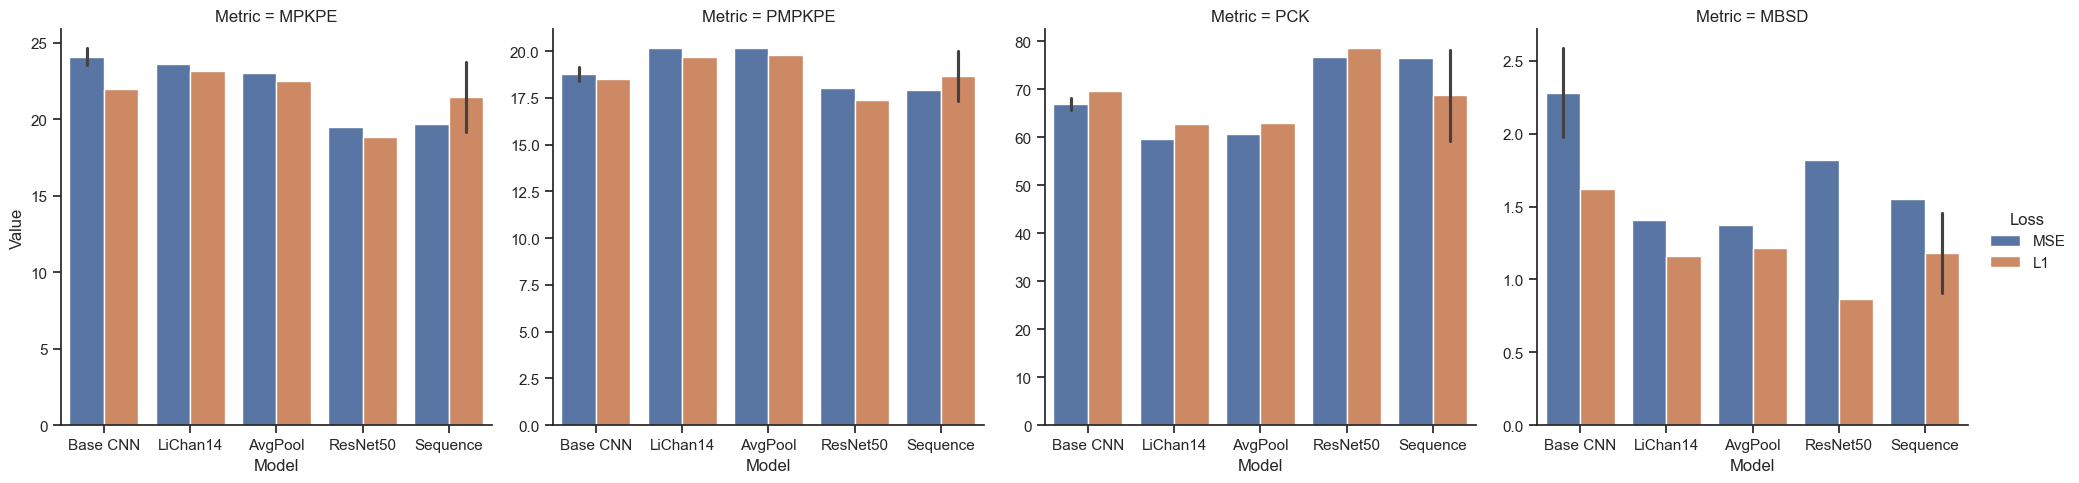

In [41]:
id_vars = ['Model', 'Loss', 'Params']
plot_df_subset = adjust_metrics_to_lower_is_better(previous).reset_index()[['Model', 'Loss', 'Params'] + skeleton_cols].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df_subset, x='Model', y='Value', hue='Loss', col='Metric', kind='bar', sharey=False)
# g.set_xticklabels(rotation=15)

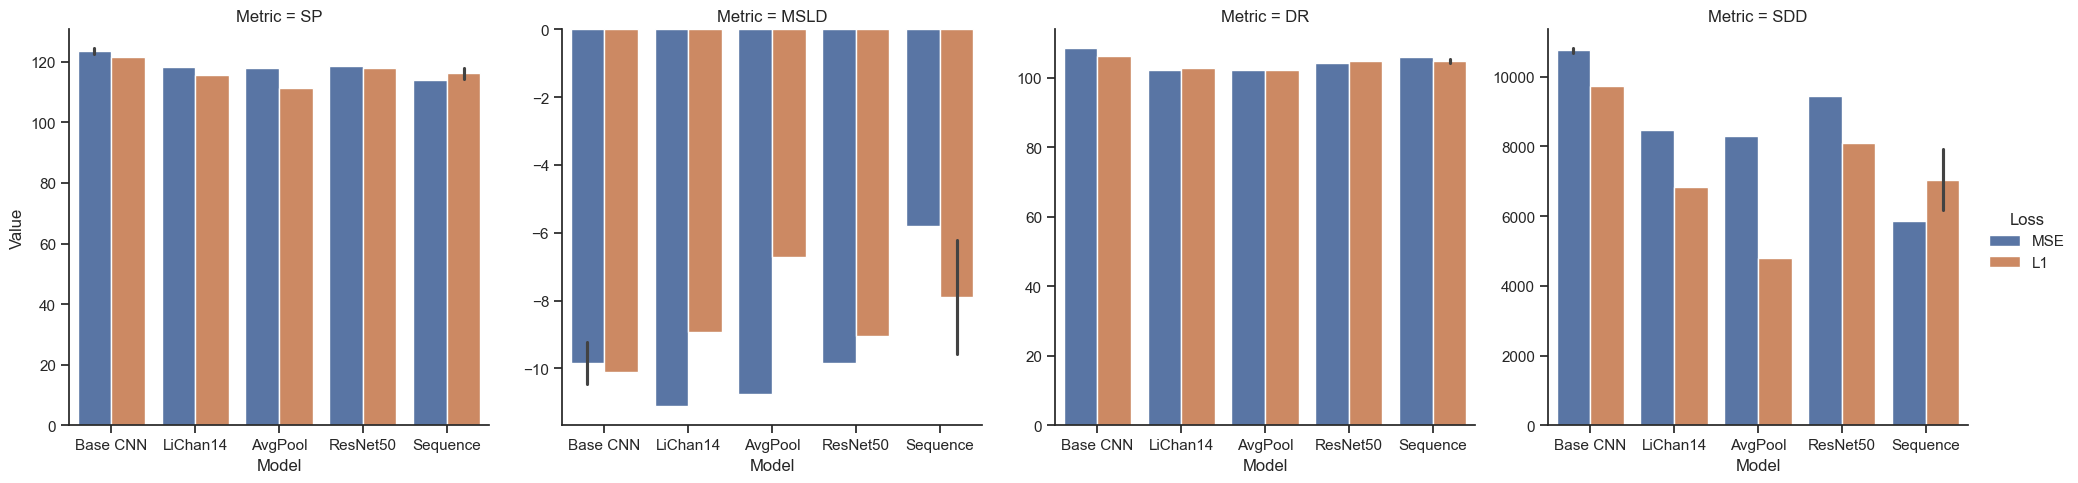

In [42]:
plot_df_subset = adjust_metrics_to_lower_is_better(previous).reset_index()[['Model', 'Loss', 'Params'] + stride_cols].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df_subset, x='Model', y='Value', hue='Loss', col='Metric', kind='bar', sharey=False)
# g.set_xticklabels(rotation=15)

In [43]:
ov

,Interp. NaN,Distance,Model,Loss,Params,Testset,MPKPE,PMPKPE,PCK,MBSD,SP,MSLD,DR,SDD
0,True,15,Base CNN,MSE,hp_default,All,24.650723,19.166742,65.741302,2.586697,159.338387,-24.664753,110.763237,31082.0
1,True,15,Base CNN,MSE,hp_default,Visible,24.009216,18.040730,68.211548,2.530413,158.686617,-24.486588,113.523760,25503.0
2,True,15,Base CNN,MSE,hp_orig,All,23.554415,18.376331,68.175995,1.977550,157.064094,-23.636057,111.190379,30911.0
3,True,15,Base CNN,MSE,hp_orig,Visible,22.889498,17.228630,70.481987,1.870482,155.361596,-23.380567,113.158040,25302.0
4,True,15,Base CNN,L1,hp_l1_loss,All,21.982121,18.514723,69.521400,1.623545,157.201930,-24.996620,108.637557,30245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,False,35,LiChan14,L1,hp_dropna,Visible,13.943005,8.884285,67.171463,1.222508,120.439560,-17.972804,104.501477,3735.0
156,False,35,AvgPool,L1,hp_dropna,All,13.666644,9.003569,67.498306,1.280858,120.069204,-17.320746,104.005749,4662.0
157,False,35,AvgPool,L1,hp_dropna,Visible,13.659091,8.998418,67.638496,1.278714,120.879121,-16.085548,106.568307,3923.0
158,False,35,ResNet50,L1,hp_dropna,All,8.974114,5.859011,85.699615,0.918500,120.242215,-17.406684,104.077667,4797.0


In [44]:
# ov[ov['Model'] == 'LSTM']

# Paper Tables

In [45]:
ov['Params'].unique()

array(['hp_default', 'hp_orig', 'hp_l1_loss', 'hp_CNNModel_LiChan2014',
       'hp_dropna'], dtype=object)

In [46]:
print_df = overview.reset_index()
# print_df = print_df[np.isin(print_df['Params'], ['hp_default', 'hp_l1_loss', 'hp_dropna', 'hp_default_OwnBaselineCNN', 'hp_CNNModel_LiChan2014'])]
print_df = print_df[np.isin(print_df['Params'], ['hp_default', 'hp_l1_loss', 'hp_dropna'])]
print_df

,Interp. NaN,Distance,Model,Loss,Params,Testset,MPKPE,PMPKPE,PCK,MBSD,SP,MSLD,DR,SDD
0,True,15,Base CNN,MSE,hp_default,All,24.650723,19.166742,65.741302,2.586697,159.338387,-24.664753,110.763237,31082.0
1,True,15,Base CNN,MSE,hp_default,Visible,24.009216,18.040730,68.211548,2.530413,158.686617,-24.486588,113.523760,25503.0
4,True,15,Base CNN,L1,hp_l1_loss,All,21.982121,18.514723,69.521400,1.623545,157.201930,-24.996620,108.637557,30245.0
5,True,15,Base CNN,L1,hp_l1_loss,Visible,21.007391,17.347113,72.024002,1.610441,156.109726,-24.741316,111.232472,25154.0
6,True,15,LiChan14,MSE,hp_default,All,23.605824,20.151007,59.562168,1.405533,151.137147,-25.216543,104.039849,27503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,False,35,LiChan14,L1,hp_dropna,Visible,13.943005,8.884285,67.171463,1.222508,120.439560,-17.972804,104.501477,3735.0
156,False,35,AvgPool,L1,hp_dropna,All,13.666644,9.003569,67.498306,1.280858,120.069204,-17.320746,104.005749,4662.0
157,False,35,AvgPool,L1,hp_dropna,Visible,13.659091,8.998418,67.638496,1.278714,120.879121,-16.085548,106.568307,3923.0
158,False,35,ResNet50,L1,hp_dropna,All,8.974114,5.859011,85.699615,0.918500,120.242215,-17.406684,104.077667,4797.0


In [47]:
# Frame Based 
id_vars = ['Interp. NaN', 'Model', 'Loss', 'Testset']
frame_based_df = print_df[np.logical_and(print_df['Distance'] == 15, np.isin(print_df['Model'], frame_based))][id_vars + skeleton_cols]
# https://stackoverflow.com/questions/64499551/formatting-of-df-to-latex
print(frame_based_df \
    .set_index(id_vars) \
    .style.highlight_max(axis=None, props='bfseries:;', subset=['PCK']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['MPKPE']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['PMPKPE']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['MBSD']) \
    .format(precision=2) \
    .to_latex(hrules=True))
frame_based_df.set_index(id_vars)

\begin{tabular}{llllrrrr}
\toprule
 &  &  &  & MPKPE & PMPKPE & PCK & MBSD \\
Interp. NaN & Model & Loss & Testset &  &  &  &  \\
\midrule
\multirow[c]{16}{*}{True} & \multirow[c]{4}{*}{Base CNN} & \multirow[c]{2}{*}{MSE} & All & 24.65 & 19.17 & 65.74 & 2.59 \\
 &  &  & Visible & 24.01 & 18.04 & 68.21 & 2.53 \\
 &  & \multirow[c]{2}{*}{L1} & All & 21.98 & 18.51 & 69.52 & 1.62 \\
 &  &  & Visible & 21.01 & 17.35 & 72.02 & 1.61 \\
 & \multirow[c]{4}{*}{LiChan14} & \multirow[c]{2}{*}{MSE} & All & 23.61 & 20.15 & 59.56 & 1.41 \\
 &  &  & Visible & 22.61 & 18.92 & 61.81 & 1.37 \\
 &  & \multirow[c]{2}{*}{L1} & All & 23.16 & 19.67 & 62.66 & 1.16 \\
 &  &  & Visible & 22.17 & 18.49 & 64.74 & 1.11 \\
 & \multirow[c]{4}{*}{AvgPool} & \multirow[c]{2}{*}{MSE} & All & 23.00 & 20.13 & 60.61 & 1.37 \\
 &  &  & Visible & 21.94 & 18.92 & 62.85 & 1.35 \\
 &  & \multirow[c]{2}{*}{L1} & All & 22.48 & 19.79 & 63.00 & 1.22 \\
 &  &  & Visible & 21.34 & 18.62 & 65.24 & 1.18 \\
 & \multirow[c]{4}{*}{ResNet50

MPKPE     PMPKPE        PCK      MBSD
Interp. NaN Model    Loss Testset                                           
True        Base CNN MSE  All      24.650723  19.166742  65.741302  2.586697
                          Visible  24.009216  18.040730  68.211548  2.530413
                     L1   All      21.982121  18.514723  69.521400  1.623545
                          Visible  21.007391  17.347113  72.024002  1.610441
            LiChan14 MSE  All      23.605824  20.151007  59.562168  1.405533
                          Visible  22.610495  18.918545  61.813141  1.368997
                     L1   All      23.159487  19.669662  62.658066  1.158554
                          Visible  22.173380  18.489927  64.744492  1.108461
            AvgPool  MSE  All      22.996250  20.134577  60.613792  1.373654
                          Visible  21.936644  18.924116  62.850258  1.346587
                     L1   All      22.476664  19.792469  63.004330  1.217412
                          Visible  21.341951  18.621788  65.242401  1.182697
            ResNet50 MSE  All      19.485071  18.020765  76.604004  1.819788
                          Visible  18.512154  16.794081  78.784149  1.758909
                     L1   All      18.828373  17.366844  78.539024  0.866660
                          Visible  17.941195  16.173828  80.516853  0.802061
False       Base CNN L1   All      12.718858   7.278790  74.942039  1.636190
                          Visible  12.456447   7.265090  75.110260  1.622324
            LiChan14 L1   All      13.979647   8.899037  67.069824  1.234453
                          Visible  13.943005   8.884285  67.171463  1.222508
            AvgPool  L1   All      13.666644   9.003569  67.498306  1.280858
                          Visible  13.659091   8.998418  67.638496  1.278714
            ResNet50 L1   All       8.974114   5.859011  85.699615  0.918500
                          Visible   8.863264   5.848619  85.908699  0.903534

In [73]:
# Frame Based 
id_vars = ['Interp. NaN', 'Model', 'Loss', 'Testset']
frame_based_df = print_df[np.logical_and(print_df['Testset'] == 'All', print_df['Interp. NaN'] == True)]
frame_based_df = frame_based_df[np.logical_and(frame_based_df['Distance'] == 15, np.isin(frame_based_df['Model'], frame_based))][id_vars + skeleton_cols]
print(frame_based_df.set_index(id_vars).min())
print(frame_based_df.set_index(id_vars).max())
frame_based_df.set_index(id_vars)

MPKPE     18.828373
PMPKPE    17.366844
PCK       59.562168
MBSD       0.866660
dtype: float64
MPKPE     24.650723
PMPKPE    20.151007
PCK       78.539024
MBSD       2.586697
dtype: float64


MPKPE     PMPKPE        PCK      MBSD
Interp. NaN Model    Loss Testset                                           
True        Base CNN MSE  All      24.650723  19.166742  65.741302  2.586697
                     L1   All      21.982121  18.514723  69.521400  1.623545
            LiChan14 MSE  All      23.605824  20.151007  59.562168  1.405533
                     L1   All      23.159487  19.669662  62.658066  1.158554
            AvgPool  MSE  All      22.996250  20.134577  60.613792  1.373654
                     L1   All      22.476664  19.792469  63.004330  1.217412
            ResNet50 MSE  All      19.485071  18.020765  76.604004  1.819788
                     L1   All      18.828373  17.366844  78.539024  0.866660

In [48]:
# plot_df[plot_df['Model'] == 'LSTM']

In [49]:
# Sequence Based (TODO: this feels to small...)
id_vars = ['Model', 'Loss', 'Testset']
frame_based_df = print_df[np.logical_and(print_df['Distance'] == 15, np.isin(print_df['Model'], sequence_based))]
frame_based_df = frame_based_df[frame_based_df['Params'] != 'hp_dropna']
frame_based_df = frame_based_df[frame_based_df['Testset'] != 'Visible'][id_vars + skeleton_cols]
print(frame_based_df \
      .set_index(id_vars) \
    .style.highlight_max(axis=None, props='bfseries:;', subset=['PCK']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['MPKPE']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['PMPKPE']) \
    .highlight_min(axis=None, props='bfseries:;', subset=['MBSD']) \
    .format(precision=2) \
    .to_latex(hrules=True))
frame_based_df.set_index(id_vars)

\begin{tabular}{lllrrrr}
\toprule
 &  &  & MPKPE & PMPKPE & PCK & MBSD \\
Model & Loss & Testset &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{Sequence} & MSE & All & 19.67 & 17.90 & 76.51 & 1.55 \\
 & L1 & All & \bfseries 19.14 & \bfseries 17.33 & \bfseries 78.18 & \bfseries 0.90 \\
\bottomrule
\end{tabular}



MPKPE     PMPKPE        PCK      MBSD
Model    Loss Testset                                           
Sequence MSE  All      19.671125  17.895760  76.506386  1.550762
         L1   All      19.142971  17.332397  78.176048  0.904839

In [66]:
# Stride Eval
id_vars = ['Interp. NaN', 'Model', 'Loss', 'Testset']
frame_based_df = print_df[np.logical_and(print_df['Distance'] == 25, np.logical_and(print_df['Testset'] == 'All', print_df['Interp. NaN'] == True))]
frame_based_df = frame_based_df[id_vars + stride_cols]
frame_based_df.set_index(id_vars).style.format(precision=2)

In [50]:
# Stride Eval
id_vars = ['Interp. NaN', 'Model', 'Loss', 'Testset']
frame_based_df = print_df[print_df['Distance'] == 25]
frame_based_df = frame_based_df[id_vars + stride_cols]
print(frame_based_df \
    .set_index(id_vars) \
    .style.highlight_min(axis=None, props='bfseries:;', subset=['SDD']) \
    .format(precision=2) \
    .to_latex(hrules=True))
frame_based_df.set_index(id_vars)

\begin{tabular}{llllrrrr}
\toprule
 &  &  &  & SP & MSLD & DR & SDD \\
Interp. NaN & Model & Loss & Testset &  &  &  &  \\
\midrule
\multirow[c]{20}{*}{True} & \multirow[c]{4}{*}{Base CNN} & \multirow[c]{2}{*}{MSE} & All & 107.38 & -0.41 & 106.82 & 2862.00 \\
 &  &  & Visible & 108.77 & -0.94 & 107.65 & 2760.00 \\
 &  & \multirow[c]{2}{*}{L1} & All & 106.20 & -0.76 & 105.21 & 2483.00 \\
 &  &  & Visible & 108.77 & -1.99 & 106.39 & 2969.00 \\
 & \multirow[c]{4}{*}{LiChan14} & \multirow[c]{2}{*}{MSE} & All & 103.62 & -1.49 & 101.76 & 1793.00 \\
 &  &  & Visible & 105.08 & -2.25 & 102.48 & 1976.00 \\
 &  & \multirow[c]{2}{*}{L1} & All & 102.14 & 0.16 & 102.29 & 2003.00 \\
 &  &  & Visible & 104.80 & -1.31 & 103.28 & 1699.00 \\
 & \multirow[c]{4}{*}{AvgPool} & \multirow[c]{2}{*}{MSE} & All & 101.92 & -0.33 & 101.48 & 1954.00 \\
 &  &  & Visible & 104.71 & -1.55 & 102.92 & 2061.00 \\
 &  & \multirow[c]{2}{*}{L1} & All & 99.34 & 2.15 & 101.80 & 3228.00 \\
 &  &  & Visible & 101.11 & 1.89 & 1

SP      MSLD          DR     SDD
Interp. NaN Model    Loss Testset                                          
True        Base CNN MSE  All      107.380074 -0.409602  106.819056  2862.0
                          Visible  108.771930 -0.938650  107.645611  2760.0
                     L1   All      106.199262 -0.758352  105.207267  2483.0
                          Visible  108.771930 -1.993889  106.392773  2969.0
            LiChan14 MSE  All      103.616236 -1.486820  101.760654  1793.0
                          Visible  105.078486 -2.254508  102.477792  1976.0
                     L1   All      102.140221  0.163918  102.293647  2003.0
                          Visible  104.801477 -1.308260  103.284916  1699.0
            AvgPool  MSE  All      101.918819 -0.330576  101.481971  1954.0
                          Visible  104.709141 -1.554356  102.922712  2061.0
                     L1   All       99.335793  2.146208  101.801275  3228.0
                          Visible  101.108033  1.885558  103.165669  1809.0
            ResNet50 MSE  All      105.387454 -1.818924  103.093348  2049.0
                          Visible  109.787627 -4.714272  104.117807  2675.0
                     L1   All      106.789668 -2.692475  103.357677  2082.0
                          Visible  108.864266 -3.887112  104.224834  2358.0
            Sequence MSE  All      104.132841  0.281766  104.443063  1329.0
                          Visible  105.447830 -0.414853  104.959739  1384.0
                     L1   All      104.649446 -0.504900  103.992549  1491.0
                          Visible  105.909511 -0.917108  104.840621  1650.0
False       Base CNN L1   All      106.079665 -4.692724  100.435186  2458.0
                          Visible  110.013717 -8.726229  100.392261  2808.0
            LiChan14 L1   All      101.677149 -3.480212   97.668984  1618.0
                          Visible  104.252401 -5.451353   98.570835  1903.0
            AvgPool  L1   All       99.580713 -2.530635   96.721280  1321.0
                          Visible  103.292181 -6.367313   96.714079  1569.0
            ResNet50 L1   All      106.918239 -5.326259  100.468547  2878.0
                          Visible  109.053498 -7.881261  100.454184  2867.0

# Lower is better modification

In [51]:
overview_lower_is_better = adjust_metrics_to_lower_is_better(overview).reset_index()
overview_lower_is_better = overview_lower_is_better[np.isin(overview_lower_is_better['Params'], ['hp_default', 'hp_l1_loss', 'hp_dropna'])]
overview_lower_is_better['Loss FN'] = overview_lower_is_better['Loss']
overview_lower_is_better['Loss | Interp. Nan'] = overview_lower_is_better['Loss FN'] + ' | ' + overview_lower_is_better['Interp. NaN'].astype(str)
overview_lower_is_better['Loss'] = overview_lower_is_better['Loss FN'] + ' | Interp. NaN = ' + overview_lower_is_better['Interp. NaN'].astype(str)
overview_lower_is_better

,Interp. NaN,Distance,Model,Loss,Params,Testset,MPKPE,PMPKPE,PCK,MBSD,SP,MSLD,DR,SDD,PCK (Err),SP (Err),MSLD (Abs),DR (Err),Loss FN,Loss | Interp. Nan
0,True,15,Base CNN,MSE | Interp. NaN = True,hp_default,All,24.650723,19.166742,65.741302,2.586697,159.338387,-24.664753,110.763237,31082.0,34.258698,59.338387,24.664753,10.763237,MSE,MSE | True
1,True,15,Base CNN,MSE | Interp. NaN = True,hp_default,Visible,24.009216,18.040730,68.211548,2.530413,158.686617,-24.486588,113.523760,25503.0,31.788452,58.686617,24.486588,13.523760,MSE,MSE | True
4,True,15,Base CNN,L1 | Interp. NaN = True,hp_l1_loss,All,21.982121,18.514723,69.521400,1.623545,157.201930,-24.996620,108.637557,30245.0,30.478600,57.201930,24.996620,8.637557,L1,L1 | True
5,True,15,Base CNN,L1 | Interp. NaN = True,hp_l1_loss,Visible,21.007391,17.347113,72.024002,1.610441,156.109726,-24.741316,111.232472,25154.0,27.975998,56.109726,24.741316,11.232472,L1,L1 | True
6,True,15,LiChan14,MSE | Interp. NaN = True,hp_default,All,23.605824,20.151007,59.562168,1.405533,151.137147,-25.216543,104.039849,27503.0,40.437832,51.137147,25.216543,4.039849,MSE,MSE | True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,False,35,LiChan14,L1 | Interp. NaN = False,hp_dropna,Visible,13.943005,8.884285,67.171463,1.222508,120.439560,-17.972804,104.501477,3735.0,32.828537,20.439560,17.972804,4.501477,L1,L1 | False
156,False,35,AvgPool,L1 | Interp. NaN = False,hp_dropna,All,13.666644,9.003569,67.498306,1.280858,120.069204,-17.320746,104.005749,4662.0,32.501694,20.069204,17.320746,4.005749,L1,L1 | False
157,False,35,AvgPool,L1 | Interp. NaN = False,hp_dropna,Visible,13.659091,8.998418,67.638496,1.278714,120.879121,-16.085548,106.568307,3923.0,32.361504,20.879121,16.085548,6.568307,L1,L1 | False
158,False,35,ResNet50,L1 | Interp. NaN = False,hp_dropna,All,8.974114,5.859011,85.699615,0.918500,120.242215,-17.406684,104.077667,4797.0,14.300385,20.242215,17.406684,4.077667,L1,L1 | False


# Distance 

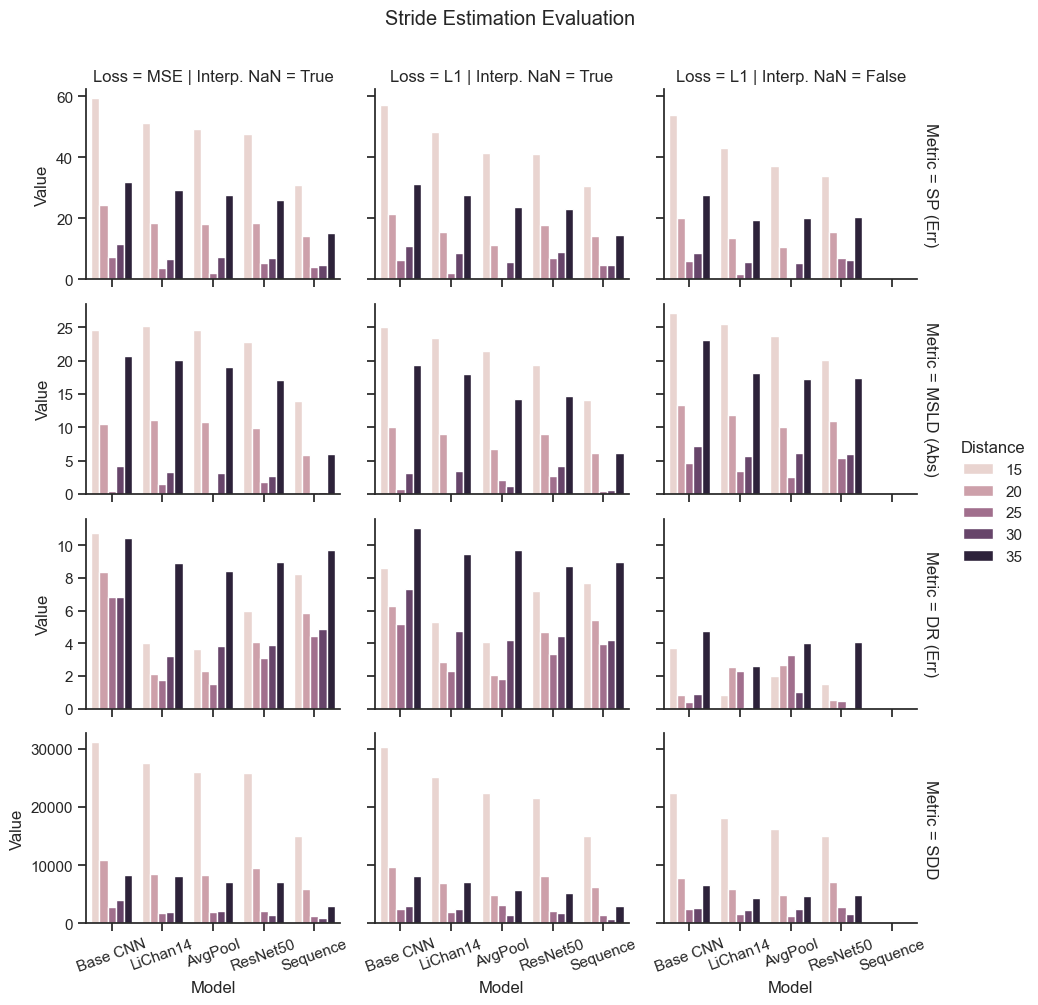

In [52]:
id_vars = ['Model', 'Loss', 'Params', 'Distance']
plot_df = overview_lower_is_better[overview_lower_is_better['Testset'] == 'All'][id_vars + stride_cols_plt].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df, x='Model', y='Value', col='Loss', row='Metric', hue='Distance', kind='bar', sharey='row', height=2.5, aspect=1.3, margin_titles=True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(20)
g.figure.subplots_adjust(top=0.9) # adjust the Figure in g
g.figure.suptitle('Stride Estimation Evaluation')
g.savefig(f'{fig_dir}/stride_estimation_eval.eps')

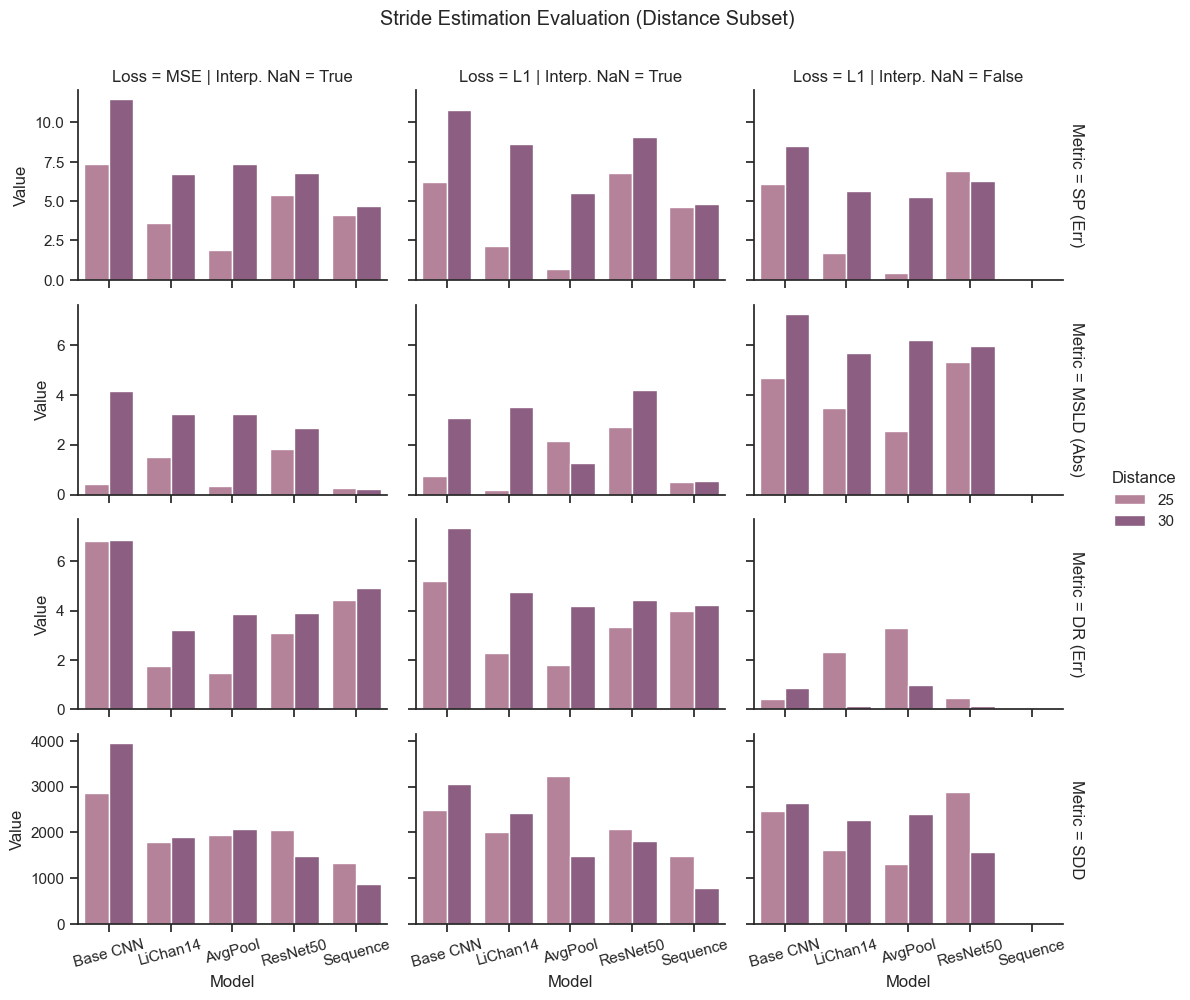

In [53]:
id_vars = ['Model', 'Loss', 'Params', 'Distance']
plot_df = overview_lower_is_better[np.logical_and(overview_lower_is_better['Testset'] == 'All', np.isin(overview_lower_is_better['Distance'], [25, 30]))][id_vars + stride_cols_plt].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df, x='Model', y='Value', col='Loss', row='Metric', hue='Distance', kind='bar', palette=sns.color_palette(np.array(sns.cubehelix_palette()[:])[[2, 3]]), sharey='row', height=2.5, aspect=1.5, margin_titles=True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(15)
g.figure.subplots_adjust(top=0.9) # adjust the Figure in g
g.figure.suptitle('Stride Estimation Evaluation (Distance Subset)')
g.savefig(f'{fig_dir}/stride_estimation_eval_subset.eps')

# Single Metrics

Text(0.5, 0.98, 'Stride Estimation Evaluation')

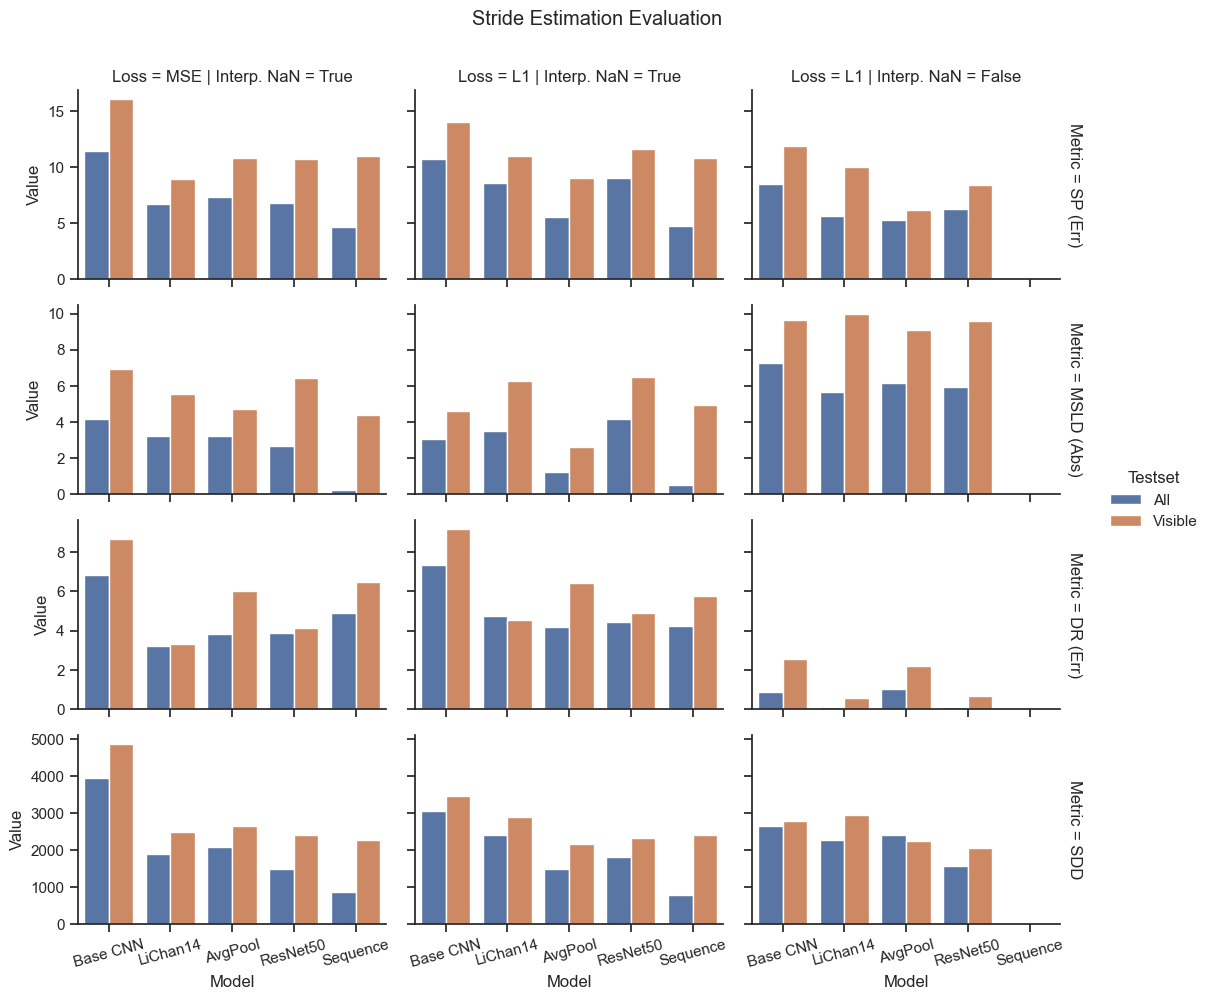

In [54]:
id_vars = ['Model', 'Loss', 'Params', 'Testset']
plot_df = overview_lower_is_better[overview_lower_is_better['Distance'] == 30][id_vars + stride_cols_plt].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df, x='Model', y='Value', col='Loss', row='Metric', hue='Testset', kind='bar', sharey='row', height=2.5, aspect=1.5, margin_titles=True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(15)
g.figure.subplots_adjust(top=0.9) # adjust the Figure in g
g.figure.suptitle('Stride Estimation Evaluation')

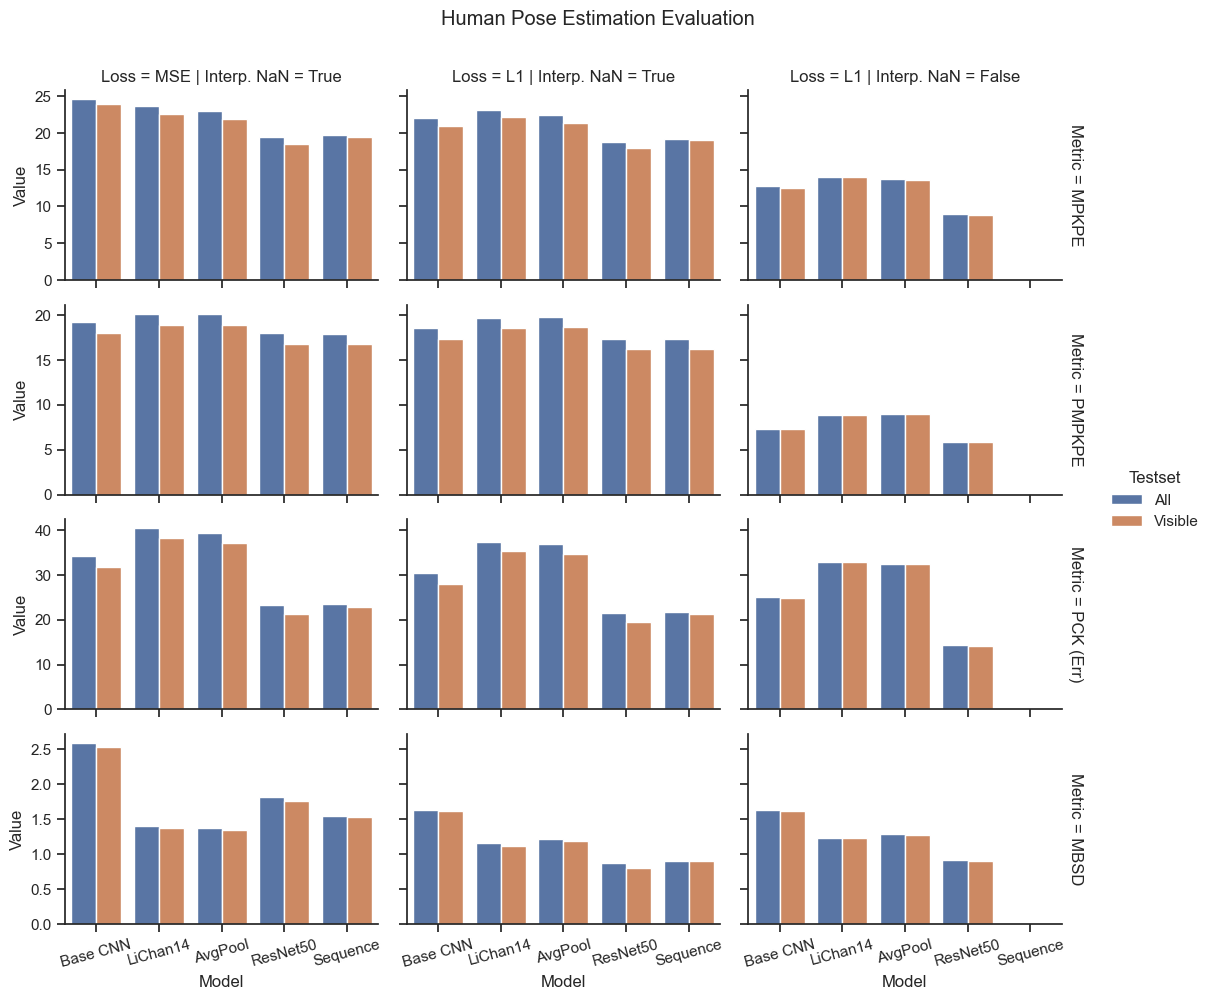

In [55]:
id_vars = ['Model', 'Loss', 'Params', 'Testset']
plot_df = overview_lower_is_better[overview_lower_is_better['Distance'] == 30][id_vars + skeleton_cols_plt].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df, x='Model', y='Value', col='Loss', row='Metric', hue='Testset', kind='bar', sharey='row', height=2.5, aspect=1.5, margin_titles=True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(15)
g.figure.subplots_adjust(top=0.9) # adjust the Figure in g
g.figure.suptitle('Human Pose Estimation Evaluation')
g.savefig(f'{fig_dir}/pose_estimation_eval.eps')

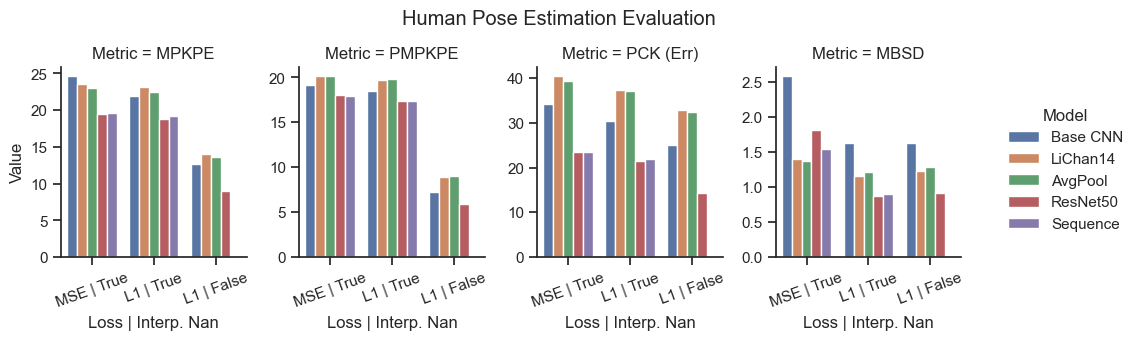

In [56]:
id_vars = ['Model', 'Loss | Interp. Nan']
plot_df = overview_lower_is_better[np.logical_and(overview_lower_is_better['Distance'] == 30, overview_lower_is_better['Testset'] == 'All')][id_vars + skeleton_cols_plt].melt(id_vars, var_name='Metric', value_name='Value')
g = sns.catplot(data=plot_df, x='Loss | Interp. Nan', y='Value', col='Metric', hue='Model', kind='bar', sharey=False, margin_titles=True, height=3.2, aspect=0.8)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(20)
g.figure.subplots_adjust(top=0.8) # adjust the Figure in g
g.figure.suptitle('Human Pose Estimation Evaluation')
g.savefig(f'{fig_dir}/pose_estimation_eval.eps')
g.savefig(f'{fig_dir}/pose_estimation_eval.svg')